In [1]:
import astropy as astropy
import astropy.units as u
import astroquery
import math
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.io import fits
from astropy.table import Table
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from astroquery.vizier import VizierClass
from astropy.coordinates import SkyCoord
import pandas as pd
import scipy as sp

In [7]:
'******************* CREATING GALAXY SAMPLE *******************'

'******************* CREATING GALAXY SAMPLE *******************'

In [8]:
def distance(x1, y1, x2, y2):
    return ((x2-x1)**2+(y2-y1)**2)**0.5

In [9]:
#SDSS DR16 query
V = Vizier(catalog = 'V/154/sdss16', columns = ['**'])
V.ROW_LIMIT = 100000000000
V.TIMEOUT = 999999
SDSSDR16 = V.query_constraints(RA_ICRS = '160.5 .. 233', DE_ICRS = '44.5 .. 57.5', rpmag = '<= 19.5', gc = '= 3', rc = '= 3', uc = '= 3', ic = '= 3', zc = '= 3')[0]

In [10]:
#calculating photometric redshift constraint
zph = []
for source in range(len(SDSSDR16)):
    zph.append(SDSSDR16[source]['zph'] - 2*SDSSDR16[source]['e_zph'])

In [11]:
#applying photometric redshift constraint to galaxies
SDSSsources = []
for source in range(len(zph)):
    if zph[source] <= 0.043:
        SDSSsources.append(SDSSDR16[source])

In [12]:
print(len(SDSSsources))

21994


In [13]:
#Gaia DR3 catalog query
V = Vizier(catalog = 'I/356/galcand', columns = ["*", 'RadS'])
V.ROW_LIMIT = 100000000000
GaiaSources = V.query_constraints(RA_ICRS = '160.5 .. 233', DE_ICRS = '44.5 .. 57.5')[0]
print(len(GaiaSources))

102702


In [14]:
#putting SDSS and Gaia source coordinates into 1D arrays from 2D 
SDSSDR16RA = []
SDSSDR16DEC = []
GaiaRA = []
GaiaDEC = []
for source in range(len(SDSSsources)):
    SDSSDR16RA.append(SDSSsources[source]['RA_ICRS'])
    SDSSDR16DEC.append(SDSSsources[source]['DE_ICRS'])
for source in range(len(GaiaSources)):
    GaiaRA.append(GaiaSources[source]['RA_ICRS'])
    GaiaDEC.append(GaiaSources[source]['DE_ICRS'])

In [15]:
#matching SDSS and Gaia sources to eachother (2'' match radius)
max_sep = 2.0 * u.arcsec
c = SkyCoord(ra=SDSSDR16RA*u.degree, dec=SDSSDR16DEC*u.degree)
catalog = SkyCoord(ra=GaiaRA*u.degree, dec=GaiaDEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
gaia = GaiaSources[idx[sep_constraint]]
print(len(gaia))

11125


In [16]:
#creating list of SDSS sources with sources matches in Gaia
SDSSGaia = []
for source in range(len(sep_constraint)):
    if sep_constraint[source] == True:
        SDSSGaia.append(SDSSsources[source])
print(len(SDSSGaia))

11125


In [17]:
#selecting Gaia source if multiple per SDSS source
GAIA = []
for source in range(len(gaia)):
    check = []
    d = distance(gaia[source]['RA_ICRS'], gaia[source]['DE_ICRS'], SDSSGaia[source]['RA_ICRS'], SDSSGaia[source]['DE_ICRS'])
    sigma = (36+gaia[source]['RadS']**2)**0.5
    check.append(math.exp(d**2/(2*sigma**2)))
    prob = max(check)
    for source in range(len(check)):
        if check[source] == prob:
            GAIA.append(gaia[source])
                    

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_56693/3429345500.py:7: RuntimeWarning: divide by zero encountered in divide
  check.append(math.exp(d**2/(2*sigma**2)))
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_56693/3429345500.py:7: UserWarning: Warning: converting a masked element to nan.
  check.append(math.exp(d**2/(2*sigma**2)))


In [18]:
#creating list to remove any source that is identified as an AGN or unlikely to be a galaxy in Gaia
removeGaia = []
for source in range(len(gaia)):
    if gaia[source]['Class'] == 'AGN':
        removeGaia.append(SDSSGaia[source])
    if gaia[source]['Class'] != 'GALAXY':
        if gaia[source]['PGal'] < 0.95:
            removeGaia.append(SDSSGaia[source])
print(len(removeGaia))

494


In [19]:
#DESI DR8 query
def DESImatching(SDSS, DESI, list):
    v = Vizier(columns=["*", "+_r"])
    for source in range(len(SDSS)):
        desi = v.query_region(SkyCoord(ra = SDSS[source]['RA_ICRS'] * u.degree, dec = SDSS[source]['DE_ICRS'] * u.degree), radius = 2 * u.arcsec, catalog = 'VII/292/north')
        if len(desi) > 0:
            DESI.append(desi[0][0])
            list.append(SDSS[source])

In [20]:
DESISources = []
SDSSDESI = []
DESImatching(SDSSsources[:4398], DESISources, SDSSDESI)

In [21]:
DESImatching(SDSSsources[4399:8796], DESISources, SDSSDESI)

In [22]:
DESImatching(SDSSsources[8796:13194], DESISources, SDSSDESI)

In [23]:
DESImatching(SDSSsources[13194:17592], DESISources, SDSSDESI)

In [24]:
DESImatching(SDSSsources[17592:], DESISources, SDSSDESI)

In [25]:
print(len(SDSSDESI))
print(len(DESISources))

19522
19522


In [26]:
#calculating photometric redshift constraint
DESIzph = []
for source in range(len(DESISources)):
    DESIzph.append(DESISources[source]['zphot']-2*DESISources[source]['e_zphot'])

In [27]:
#removing any source identified as needing to be removed in Gaia and removing sources due to photometric redshift constraint and classification in DESI
keepDESI = []
for source in range(len(DESISources)):
    if DESIzph[source] <= 0.043 and DESISources[source]['type'] != 'PSF':
        for s in range(len(removeGaia)):
            if SDSSDESI[source]['objID'] == removeGaia[s]['objID']:
                pass
        keepDESI.append(source)


In [28]:
#creating final list of SDSS and DESI sources 
finalSDSS = []
finalDESI = []
for source in range(len(keepDESI)):
    finalSDSS.append(SDSSDESI[keepDESI[source]])
    finalDESI.append(DESISources[keepDESI[source]])
print(len(finalSDSS))

11981


In [29]:
import numpy as np
import mocpy
import astropy.units as u
def check_coverage(ra, dec, moc_file):
    """
    Check if the given array of Right Ascension (RA) and Declination (Dec) coordinates are covered within a Multi-Order Coverage (MOC) file.

    Args:
        ra (array-like): Array of Right Ascension coordinates.
        dec (array-like): Array of Declination coordinates.
        moc_file (str): Path to the MOC file.

    Returns:
        numpy.ndarray: Boolean array indicating whether each coordinate is covered (True) or not (False).
    """
    # Load the MOC file
    moc = mocpy.MOC.from_fits(moc_file)

    # Convert RA and Dec arrays to numpy arrays
    ra = np.array(ra)
    dec = np.array(dec)

    # Check if coordinates are covered by the MOC
    is_covered = moc.contains(ra*u.deg, dec*u.deg)

    return is_covered

ModuleNotFoundError: No module named 'mocpy'

In [ ]:
result = check_coverage(RA, DEC, '/Users/sarahpelesky/Documents/LOFAR Survey code/LOTSS_DR1_CMAP.fits')
print(result)

In [423]:
#creating arrays of source coordinates
RA = []
DEC = []
for source in range(len(finalSDSS)):
    RA.append(finalSDSS[source]['RA_ICRS'])
    DEC.append(finalSDSS[source]['DE_ICRS'])

In [ ]:
#checking sources inside LoTSS DR1 MOC map
true = []
for i in range(len(result)):
    if result[i] == True:
        true.append(i)
print(len(true))

8805


In [ ]:
#creating arrays of sources
sdss1 = []
desi = []
for source in range(len(finalSDSS)):
    if source in true:
        sdss1.append(finalSDSS[source])
        desi.append(finalDESI[source])
print(len(sdss1))
print(len(desi))

8805
8805


In [ ]:
#checking SDSS source flags
sdss = []
for source in range(len(sdss1)):
    if sdss1[source]['flags'] <= 200000000000000:
        sdss.append(sdss1[source])
print(len(sdss))

8202


In [ ]:
#checking SDSS spectroscopic redshift constraint
z = []
for source in range(len(sdss)):
    if sdss[source]['zsp'] <= 0.043:
        z.append(sdss[source])
print(len(z))

2434


In [ ]:
#creating file columns for final galaxy source list
SDSSsource = []
RA = []
DEC = []
Class = []
rPrad = []
umag = []
rmag = []
gmag = []
imag = []
zmag = []
ZPH = []
ezph = []
zsp = []
flag = []
DESIsource = []
desira = []
desidec = []
desizph = []
desiezph = []

for source in range(len(sdss)):
    SDSSsource.append(sdss[source]['objID'])
    RA.append(sdss[source]['RA_ICRS'])
    DEC.append(sdss[source]['DE_ICRS'])
    Class.append(sdss[source]['class'])
    rPrad.append(sdss[source]['rPrad'])
    umag.append(sdss[source]['uPmag'])
    rmag.append(sdss[source]['rPmag'])
    gmag.append(sdss[source]['gPmag'])
    imag.append(sdss[source]['iPmag'])
    zmag.append(sdss[source]['zPmag'])
    ZPH.append(sdss[source]['zph'])
    ezph.append(sdss[source]['e_zph'])
    DESIsource.append(desi[source]['id'])
    desira.append(desi[source]['RAJ2000'])
    desidec.append(desi[source]['DEJ2000'])
    desizph.append(desi[source]['zphot'])
    desiezph.append(desi[source]['e_zphot'])
    zsp.append(sdss[source]['zsp'])
    flag.append(sdss[source]['flags'])

In [ ]:
def makefile():
    data = Table()
    data['SDSS Source'] = np.array(SDSSsource, dtype = np.int64)
    data['RA_ICRS'] = np.array(RA, dtype = np.float64)
    data['DE_ICRS'] = np.array(DEC, dtype = np.float64)
    data['class'] = np.array(Class, dtype = np.float64)
    data['rPrad'] = np.array(rPrad, dtype = np.float64)
    data['umag'] = np.array(umag, dtype = np.float64)
    data['rmag'] = np.array(rmag, dtype = np.float64)
    data['gmag'] = np.array(gmag, dtype = np.float64)
    data['imag'] = np.array(imag, dtype = np.float64)
    data['zmag'] = np.array(zmag, dtype = np.float64)
    data['zph'] = np.array(ZPH, dtype = np.float64)
    data['e_zph'] = np.array(ezph, dtype = np.float64)
    data['DESI Source'] = np.array(DESIsource, dtype = np.int64)
    data['RAJ2000'] = np.array(desira, dtype = np.float64)
    data['DEJ2000'] = np.array(desidec, dtype = np.float64)
    data['zphot'] = np.array(desizph, dtype = np.float64)
    data['e_zphot'] = np.array(desiezph, dtype = np.float64)
    data['flag'] = np.array(flag, dtype = np.int64)
    data['zsp'] = np.array(zsp, dtype = np.float64)
    ascii.write(data, 'SDSSgalaxies.txt', overwrite=True)
    data.write('SDSSgalaxies.fits', format = 'fits',overwrite=True)
    
makefile()

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/2368038253.py:21: UserWarning: Warning: converting a masked element to nan.
  data['zsp'] = np.array(zsp, dtype = np.float64)


In [ ]:
'******************* RADIO SOURCE ANALYSIS *******************'

In [10]:
#open galaxy sample file
file = astropy.io.fits.open('SDSSgalaxies.fits')
SDSS = file[1].data

In [11]:
#calculation variables
offset1 = 1.28
A1 = 2.10
B1 = -0.51
offset2 = 1.34
A2 = 2.79
B2 = -0.48

In [13]:
#LoTSS DR1 query with PRS constraints 
v = Vizier(columns=["*", "+_r"])
DR1res = 6
DR1 = []
SDSSDR1 = []
DR1flag = []
for source in range(len(SDSS)):
    dr1 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = max(2*SDSS[source]['rPrad'], DR1res) * u.arcsec, catalog = 'J/A+A/622/A1/lotssdr1')
    if len(dr1) > 0:
        if len(dr1[0]) > 1:
            inEnvelope = []
            for ourc in range(len(dr1[0])):
                ratio = dr1[0][ourc]['Sint']/dr1[0][ourc]['Speak']
                calculated = offset1 + A1 * (dr1[0][ourc]['Speak']/dr1[0][ourc]['rms']) ** B1
                if ratio < calculated:
                    inEnvelope.append(True)
                else:
                    inEnvelope.append(False)
            c = 0
            rem = 0
            for so in range(len(inEnvelope)):
                if inEnvelope[so] == True:
                    c += 1
                    ind = so
                else:
                    dr1[0].remove_row(so-rem)
                    rem += 1
            if c > 1:
                sint = []
                for sou in range(len(dr1[0])):
                    if dr1[0][sou]['Sint'] > 0.8:
                        sint.append(True)
                    else:
                        sint.append(False)
                s = 0
                rem = 0
                for sour in range(len(sint)):
                    if sint[sour] == True:
                        s += 1
                        ind = sour
                    else:
                        dr1[0].remove_row(sour-rem)
                        rem += 1
                if s > 1:
                    Type = []
                    for sourc in range(len(dr1[0])):
                        if dr1[0][sourc]['Type'] == 'S':
                            Type.append(True)
                        else:
                            Type.append(False)
                    t = 0
                    rem = 0
                    for ource in range(len(Type)):
                        if Type[ource] == True:
                            t += 1
                            ind = ource
                        else:
                            dr1[0].remove_row(ource-rem)
                            rem += 1
                    if t > 1:
                        DR1.append(dr1[0][0])
                        SDSSDR1.append(SDSS[source])
                        DR1flag.append(1)
                    else:
                        if t == 1:
                            DR1.append(dr1[0][0])
                            SDSSDR1.append(SDSS[source])
                            DR1flag.append(1)
                else:
                    if s == 1:
                        DR1.append(dr1[0][0])
                        SDSSDR1.append(SDSS[source])
                        DR1flag.append(1)
            else:
                if c == 1:
                    DR1.append(dr1[0][0])
                    SDSSDR1.append(SDSS[source])
                    DR1flag.append(1)
        else:
            DR1.append(dr1[0][0])
            SDSSDR1.append(SDSS[source])
            DR1flag.append(0)

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/756708699.py:13: RuntimeWarning: divide by zero encountered in float_scalars
  ratio = dr1[0][ourc]['Sint']/dr1[0][ourc]['Speak']
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/756708699.py:14: RuntimeWarning: divide by zero encountered in power
  calculated = offset1 + A1 * (dr1[0][ourc]['Speak']/dr1[0][ourc]['rms']) ** B1


In [14]:
print(len(DR1))

2615


In [15]:
#manually checking compactness constraint
ratio = []
calculated = []
inEnvelope = []
for source in range(len(DR1)):
    ratio.append(DR1[source]['Sint']/DR1[source]['Speak'])
    calculated.append(offset1 + A1 * (DR1[source]['Speak']/DR1[source]['rms']) ** B1)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        inEnvelope.append(True)
    else:
        inEnvelope.append(False)
        
compact1 = []
sdsscompact1 = []
for source in range(len(inEnvelope)):
    if inEnvelope[source] == True:
        compact1.append(DR1[source])
        sdsscompact1.append(SDSSDR1[source])
print(len(compact1))

1110


/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/384291470.py:5: RuntimeWarning: divide by zero encountered in float_scalars
  ratio.append(DR1[source]['Sint']/DR1[source]['Speak'])
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/384291470.py:6: RuntimeWarning: divide by zero encountered in power
  calculated.append(offset1 + A1 * (DR1[source]['Speak']/DR1[source]['rms']) ** B1)


In [16]:
#manually checking source type
Compact1 = []
sdssCompact1 = []
for source in range(len(compact1)):
    if compact1[source]['Type'] == 'S':
        Compact1.append(compact1[source])
        sdssCompact1.append(sdsscompact1[source])
print(len(Compact1))

1078


In [17]:
#manually checking integrated flux limit
c1 = []
sdssc1 = []
for source in range(len(Compact1)):
    if Compact1[source]['Sint'] > 0.8:
        c1.append(Compact1[source])
        sdssc1.append(sdssCompact1[source])
print(len(c1))

709


In [18]:
#LoTSS DR2 query with PRS constraints
v = Vizier(columns=["*", "+_r"])
DR2res = 6
DR2 = []
SDSSDR2 = []
DR2flag = []
for source in range(len(SDSS)):
    dr2 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = max(2*SDSS[source]['rPrad'], DR2res) * u.arcsec, catalog = 'J/A+A/659/A1/catalog')
    if len(dr2) > 0:
        if len(dr2[0]) > 1:
            inEnvelope = []
            for ourc in range(len(dr2[0])):
                ratio = dr2[0][ourc]['SpeakTot']/dr2[0][ourc]['Speak']
                calculated = offset2 + A2 * (dr2[0][ourc]['Speak']/dr2[0][ourc]['Islrms']) ** B2
                if ratio < calculated:
                    inEnvelope.append(True)
                else:
                    inEnvelope.append(False)
            c = 0
            rem = 0
            for so in range(len(inEnvelope)):
                if inEnvelope[so] == True:
                    c += 1
                    ind = so
                else:
                    dr2[0].remove_row(so-rem)
                    rem += 1
            if c > 1:
                sint = []
                for sou in range(len(dr2[0])):
                    if dr2[0][sou]['SpeakTot'] > 0.8:
                        sint.append(True)
                    else:
                        sint.append(False)
                s = 0
                rem = 0
                for sour in range(len(sint)):
                    if sint[sour] == True:
                        s += 1
                        ind = sour
                    else:
                        dr2[0].remove_row(sour-rem)
                        rem += 1
                if s > 1:
                    Type = []
                    for sourc in range(len(dr2[0])):
                        if dr2[0][sourc]['SCode'] == 'S':
                            Type.append(True)
                        else:
                            Type.append(False)
                    t = 0
                    rem = 0
                    for ource in range(len(Type)):
                        if Type[ource] == True:
                            t += 1
                            ind = ource
                        else:
                            dr2[0].remove_row(ource-rem)
                            rem += 1
                    if t > 1:
                        DR2.append(dr2[0][0])
                        SDSSDR2.append(SDSS[source])
                        DR2flag.append(1)
                    else:
                        if t == 1:
                            DR2.append(dr2[0][0])
                            SDSSDR2.append(SDSS[source])
                            DR2flag.append(1)
                else:
                    if s == 1:
                        DR2.append(dr2[0][0])
                        SDSSDR2.append(SDSS[source])
                        DR2flag.append(1)
            else:
                if c == 1:
                    DR2.append(dr2[0][0])
                    SDSSDR2.append(SDSS[source])
                    DR2flag.append(1)
        else:
            DR2.append(dr2[0][0])
            SDSSDR2.append(SDSS[source])
            DR2flag.append(0)

In [19]:
print(len(DR2))

3214


In [20]:
#manually calculating compactness constraint
ratio2 = []
calculated2 = []
inEnvelope2 = []
for source in range(len(DR2)):
    ratio2.append(DR2[source]['SpeakTot']/DR2[source]['Speak'])
    calculated2.append(offset2 + A2 * (DR2[source]['Speak']/DR2[source]['Islrms']) ** B2)
for source in range(len(ratio2)):
    if ratio2[source] < calculated2[source]:
        inEnvelope2.append(True)
    else:
        inEnvelope2.append(False)
        
compact2 = []
sdsscompact2 = []
for source in range(len(inEnvelope2)):
    if inEnvelope2[source] == True:
        compact2.append(DR2[source])
        sdsscompact2.append(SDSSDR2[source])
print(len(compact2))

1296


In [21]:
#manually checking source type
Compact2 = []
sdssCompact2 = []
for source in range(len(compact2)):
    if compact2[source]['SCode'] == 'S':
        Compact2.append(compact2[source])
        sdssCompact2.append(sdsscompact2[source])
print(len(Compact2))

1268


In [22]:
#manually checking integrated flux limit
c2 = []
sdssc2 = []
for source in range(len(Compact2)):
    if Compact2[source]['SpeakTot'] > 1.23:
        c2.append(Compact2[source])
        sdssc2.append(sdssCompact2[source])
print(len(c2))

485


In [23]:
#creating arrays of source coordinates
DR1RA = []
DR1DEC = []
for source in range(len(c1)):
    DR1RA.append(c1[source]['RAJ2000'])
    DR1DEC.append(c1[source]['DEJ2000'])
DR2RA = []
DR2DEC = []
for source in range(len(c2)):
    DR2RA.append(c2[source]['RAJ2000'])
    DR2DEC.append(c2[source]['DEJ2000'])

In [24]:
#crossmatching LoTSS DR1 and DR2 source with 2'' match radius 
max_sep = 2.0 * u.arcsec
c = SkyCoord(ra=DR1RA*u.degree, dec=DR1DEC*u.degree)
catalog = SkyCoord(ra=DR2RA*u.degree, dec=DR2DEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]
print(len(catalog_matches))

408


In [25]:
#checking sources for match
DR2matches = []
DR1matches = []
SDSSDR1matches = []
SDSSDR2matches = []
for source in range(len(sep_constraint)):
    if sep_constraint[source] == True:
        DR1matches.append(c1[source])
        SDSSDR1matches.append(sdssc1[source])
for source in range(len(idx[sep_constraint])):
    SDSSDR2matches.append(sdssc2[idx[sep_constraint][source]])
    DR2matches.append(c2[idx[sep_constraint][source]])

In [26]:
#checking SDSS galaxy spectroscopic redshift
zspSDSSDR1 = []
zspDR1 = []
zspSDSSDR2 = []
zspDR2 = []
for source in range(len(DR1matches)):
    if SDSSDR1matches[source]['zsp'] <= 0.043:
        zspSDSSDR1.append(SDSSDR1matches[source])
        zspDR1.append(DR1matches[source])
    if SDSSDR2matches[source]['zsp'] <= 0.043:
        zspSDSSDR2.append(SDSSDR2matches[source])
        zspDR2.append(DR2matches[source])
print(len(zspSDSSDR1))

136


In [153]:
#difference in flux in sources in LoTSS DR1 and DR2
#don't change
diff = []
for source in range(len(zspDR1)):
    diff.append(zspDR2[source]['SpeakTot']-zspDR1[source]['Sint'])

0.4269999880790709

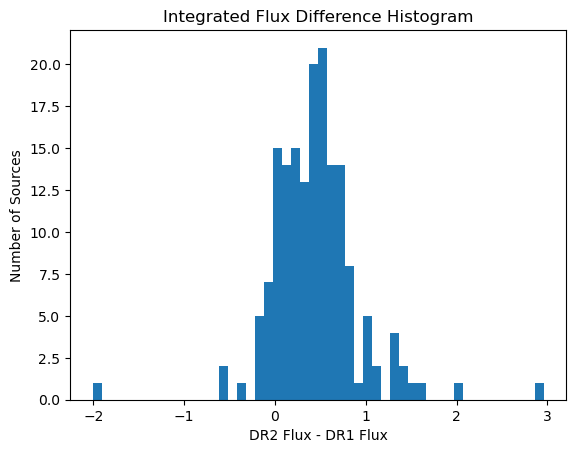

In [154]:
#plotting the integrated flux differences histogram
plt.hist(diff, bins=50)
plt.xlabel('DR2 Flux - DR1 Flux')
plt.ylabel('Number of Sources')
plt.title('Integrated Flux Difference Histogram')
np.median(diff)

In [115]:
 #creation of WISE color-color plot
 def galaxy_association_plot():
        fig, ax = plt.subplots(figsize=(8, 10))
        img = plt.imread("WISE_color (2).png")
        ax.imshow(img, extent=[-1, 7, -0.5, 4], aspect="auto")
        ax.scatter(W23, W12, color="black",s=5)
        ax.errorbar(
            W23,
            W12,
            xerr=W23_err,
            yerr=W12_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1,
        )
        
        ylabel = "[3.4] - [4.6] in mag"
        xlabel = "[4.6] - [12] in mag"
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=18)
        ax.set_ybound(lower=-0.5, upper=4)
        ax.set_xbound(lower=-1, upper=7)
        ax.tick_params(axis="both", which="both", labelsize=16, length=0)
        plt.show()
        # plt.close()

In [116]:
img = plt.imread("WISE_color (2).png")

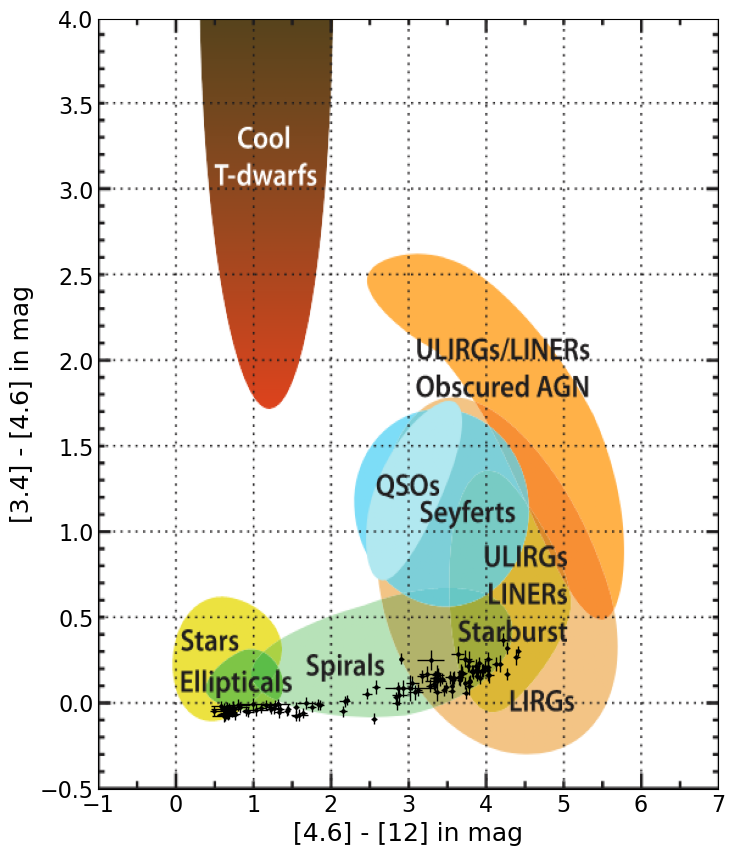

In [127]:
import os.path
WISEfile = astropy.io.ascii.read('WISE Data - Sheet1.csv')
W12 = np.array(WISEfile['W12']).astype(np.float64)
W23 = np.array(WISEfile['W23']).astype(np.float64)
W1_err = np.array(WISEfile['e_W1mag']).astype(np.float64)
W2_err = np.array(WISEfile['e_W2mag']).astype(np.float64)
W3_err = np.array(WISEfile['e_W3mag']).astype(np.float64)
W23_err = []
W12_err = []
for i in range(len(W1_err)):
    W23_err.append(np.sqrt(W2_err[i]**2 + W3_err[i]**2))
    W12_err.append(np.sqrt(W1_err[i]**2 + W2_err[i]**2))
galaxy_association_plot()

In [2]:
'******************* FINAL RADIO SOURCE CANDIDATE ANALYSIS *******************'

'******************* FINAL RADIO SOURCE CANDIDATE ANALYSIS *******************'

In [21]:
#opening final source list file and data accoess
finalList = astropy.io.ascii.read('Final Source List - Sheet1.csv')
Vohl = astropy.io.ascii.read('Vohl Sources - Sheet1.csv')
Vmass = np.array(Vohl['mass'][:41]).astype(np.float64)
Vflux = np.array(Vohl['Sint'][:41]).astype(np.float64)
Vredshift = np.array(Vohl['z'][:41]).astype(np.float64)
mass = np.array(finalList['Log(Mass)'][:37]).astype(np.float64)
#removing 0 mass data point
for source in range(len(mass)):
    if mass[source] <= 1:
        mass = np.delete(mass, source)
        break
xray = np.array(finalList['X-ray'][:35]).astype(np.float64)
LOTSSFlux = np.array(finalList['SpeakTot'][:35]).astype(np.float64)
redshift = np.array(finalList['zsp'][:35]).astype(np.float64)
error = np.array(finalList['e_Sint'][:35]).astype(np.float64)
OIII5008 = np.array(finalList['OIII5008'][:35]).astype(np.float64)
OIII5008_err = np.array(finalList['OIII5008_err'][:35]).astype(np.float64)
HBeta = np.array(finalList['HBeta'][:37]).astype(np.float64)
HBeta_err = np.array(finalList['HBeta_err'][:35]).astype(np.float64)
NII6549 = np.array(finalList['NII6548'][:35]).astype(np.float64)
NII6549_err = np.array(finalList['NII6548_err'][:35]).astype(np.float64)
HAlpha = np.array(finalList['HAlpha'][:35]).astype(np.float64)
HAlpha_err = np.array(finalList['HAlpha_err'][:38]).astype(np.float64)
SIIsummed = np.array(finalList['SII6717'][:38]).astype(np.float64)
SIIsummed_err = np.array(finalList['e_SII6717'][:38]).astype(np.float64)
OI6302 = np.array(finalList['OI6302'][:38]).astype(np.float64)
OI6302_err = np.array(finalList['OI6302_err'][:38]).astype(np.float64)
Wa = np.array(finalList['flux/cont (WHa)'][:38]).astype(np.float64)
cont_err = np.array(finalList['cont_err'][:38]).astype(np.float64)
FIRSTFlux = np.array(finalList['FIRST Flux (mJy)'][:38]).astype(np.float64)
HECATEsfr = np.array(finalList['Log(SFR)'][:38]).astype(np.float64)
SDSSRA = np.array(finalList['RA'][:38]).astype(np.float64)
SDSSDEC = np.array(finalList['DEC'][:38]).astype(np.float64)
LOTSSRA = np.array(finalList['RA2'][:38]).astype(np.float64)
LOTSSDEC = np.array(finalList['DEC2'][:38]).astype(np.float64)
ks = np.array(finalList['Ks mag'][:38]).astype(np.float64)

[10.094 10.155  9.92   9.949 10.4    9.254  9.762  9.936  8.837  9.803
 10.456 10.107  9.947 10.181  9.721  9.998 10.377  9.884  9.539  9.654
  9.726  9.917  9.252  9.6    9.157 10.214  9.704 10.547 10.8    9.466
 11.137 10.68   9.903]


In [4]:
#coronal line survey query 
Coronal = []
v = Vizier(columns=['all'])
for source in range(len(SDSSRA)):
    coronal = v.query_region(SkyCoord(ra = SDSSRA[source]* u.degree, dec = SDSSDEC[source] * u.degree), radius = 2 * u.arcsec, catalog = 'J/ApJS/265/21/catalog')
    if len(coronal) > 0:
        Coronal.append(coronal[0][0])

In [5]:
#SDSS DR16 query for data access
SDSSdata = []
v = Vizier(columns=['all'])
for source in range(len(SDSSRA)):
    sdss = v.query_region(SkyCoord(ra = SDSSRA[source]* u.degree, dec = SDSSDEC[source] * u.degree), radius = 2 * u.arcsec, catalog = 'V/154/sdss16')
    if len(sdss) > 0:
        SDSSdata.append(sdss[0][0])

In [6]:
#calculating spectral index
spec = []
spec_err = []
spectral = []
vlasssint = []
firstsint = []
for source in range(len(LOTSSFlux)):
    alpha = np.log(LOTSSFlux[source]/FIRSTFlux[source])/np.log(144/1400)
    spec.append(alpha)
    spectral.append(np.log(LOTSSFlux[source]/0.48)/np.log(144/3000))
for source in range(len(spectral)):
    vlasssint.append((FIRSTFlux[source])/((1400/3000)**spectral[source]))
    firstsint.append(0.48/((3000/1400)**spec[source]))
print(spec)
print(spec_err)
print(spectral)
print(vlasssint)
print(firstsint)

[-0.5331492049596867, -0.9547352797905525, -0.6623874748298493, -0.9682276342427658, -0.7197691027127262, -0.5582802534015952, -0.5736521950276052, -0.748999555054105, -0.524936249544651, -0.5033956680467675, -0.9198581145559834, -0.6431286158455339, -0.8959454703835369, -0.8121780114876858, -0.5783969207493841, -0.8707919512059267, -0.8629015563720838, -0.577346953325, -0.7003371444225666, -0.668837570702631, -0.813255077835612, -0.534599795684969, -0.6309688513097413, -0.6191806478849987, -0.7409220409753068, -0.4993347102606155, -0.6365168574162331, -0.5951165645685563, -0.5533121366995856, -0.49013817169530927, -0.5465994315013849, -0.8338204547501707, -0.4633829672077655, -0.5049476415961107]
[]
[-0.37808104467519044, -0.6938538836314302, -0.47488200138389164, -0.7039598129396705, -0.5178615033699946, -0.3969044901972749, -0.40841825200608745, -0.5397554497568986, -0.3719294462177052, -0.3557953019030862, -0.667730484073501, -0.4604568935836046, -0.6498196374206243, -0.58707684327

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_68251/1078773549.py:11: RuntimeWarning: invalid value encountered in scalar divide
  yPRS_err.append((OIII5008[source]/HBeta[source])*np.sqrt((OIII5008_err[source]/OIII5008[source])**2+(HBeta_err[source]/HBeta[source])**2))


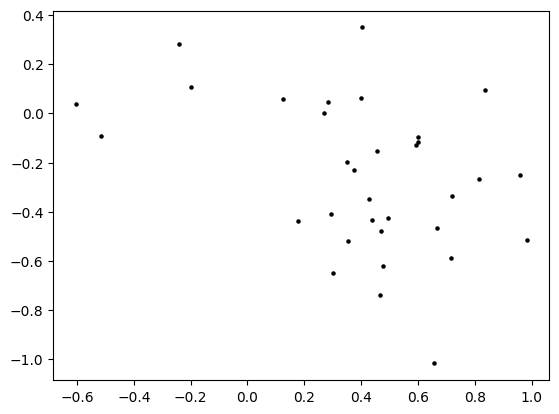

In [7]:
#calculating radio loudness
loudness = []
yPRS = []
yPRS_err = []
g = np.array(finalList['gmag'][:41]).astype(np.float64)
for source in range(len(LOTSSFlux)-1):
    m = -2.5*np.log10((LOTSSFlux[source]/1000)/3631)
    R = 0.4*(g[source]-m)
    loudness.append(R)
    yPRS.append(OIII5008[source]-HBeta[source])
    yPRS_err.append((OIII5008[source]/HBeta[source])*np.sqrt((OIII5008_err[source]/OIII5008[source])**2+(HBeta_err[source]/HBeta[source])**2))
plt.scatter(loudness, yPRS, s=5, c='black')


In [8]:
#calculating starformation rate and converting integrated flux to radio luminosity 
from astropy.cosmology import Planck18 as cosmo
SFRcorr = []
SFRerr = []
Flux = []
VFlux = []
Flux_err = []
for source in range(len(redshift)):
    D = cosmo.luminosity_distance(z = redshift[source])
    Dis = D.to(u.cm).value
    Ha = HAlpha[source]
    Hb = HBeta[source]
    if Hb == 0 or Ha/Hb > 2.86:
        E = 1.97 * np.log10((Ha/Hb)/2.86)
    else:
        E = 0
    ha = Ha * (10**(-17)) * 10 ** (0.4*3.327*E)
    HA = ha * 4 * np.pi * Dis**2
    Fin = (5.5 * 10**(-42)) * HA
    SFRcorr.append(Fin)
    if Ha != 0:
        SFRerr.append(Fin*np.sqrt((HAlpha_err[source]/Ha)**2+0.15**2))
    else:
        SFRerr.append(0.15*Fin)
for source in range(len(LOTSSFlux)):
    d = cosmo.luminosity_distance(z = redshift[source])
    dis = d.to(u.m).value
    sint = LOTSSFlux[source] * 10**(-29)
    fin = sint * 4 * np.pi * dis**2
    err = error[source] * 10**(-29)
    finerr = err * 4 * np.pi * dis**2
    Flux.append(fin)
    Flux_err.append(finerr)
for source in range(len(Vflux)):
    d = cosmo.luminosity_distance(z = Vredshift[source])
    dis = d.to(u.m).value
    sint = Vflux[source] * 10**(-29)
    fin = sint * 4 * np.pi * dis**2
    VFlux.append(fin)
print(SFRcorr)
print(SFRerr)
print(len(SFRcorr))

[0.009523006448703068, 0.0059846713712373364, 0.0074833872209642115, 0.003506739295587718, 0.008363932004849315, 0.0033474445346222143, 0.008776344273364439, 0.005478484259647223, 0.004158842733510468, 0.007513983326343194, 0.008299160374158034, 0.0, 0.005190610166313872, 0.006261815367299855, 0.00711113382466375, 0.007479510067505513, nan, 0.010198348178141912, 0.00972005910566984, 0.0030934920370382568, 0.005593318799878998, 0.004762272266839543, 0.005199469055521311, 0.006086257428575898, 0.003546769654839013, 0.005849223554287391, 0.008109225530607708, 0.009155147403692294, 0.0035551255373800707, 0.008395898932902856, 0.008075666910006794, 0.0035165913520997377, 0.0034985860794643575, 0.005260298201092225]
[0.0014284516647619606, 0.0008977008994364811, 0.0011225083271801982, 0.0005260110076660454, 0.001254590072375074, 0.00050211674096673, 0.0013164520887222818, 0.0008217730480721715, 0.0006238268451266324, 0.001127097878280999, 0.0012448744766840123, 0.0, 0.0007785917940251605, 0.

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_68251/3975141271.py:14: RuntimeWarning: invalid value encountered in scalar divide
  E = 1.97 * np.log10((Ha/Hb)/2.86)


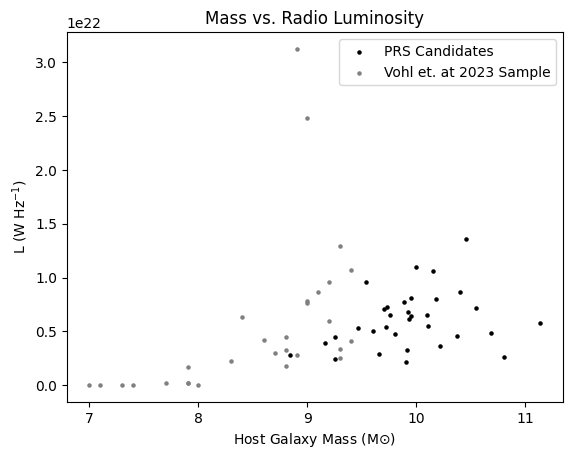

In [22]:
#plotting mass vs. radio luminosity 
for source in range(len(mass)):
    if mass[source] != 0:
        if source == 1:
            plt.scatter(mass[source], Flux[source], c='black',s=5, label='PRS Candidates')
        else:
            plt.scatter(mass[source], Flux[source], c='black',s=5)
plt.scatter(Vmass, VFlux, c='grey',s=5, label='Vohl et. at 2023 Sample')
plt.xlabel('Host Galaxy Mass (M' r'$\odot$' ')')
plt.ylabel('L (W Hz$^{-1}$)')
plt.title('Mass vs. Radio Luminosity')
plt.legend()

Text(0, 0.5, 'SFR')

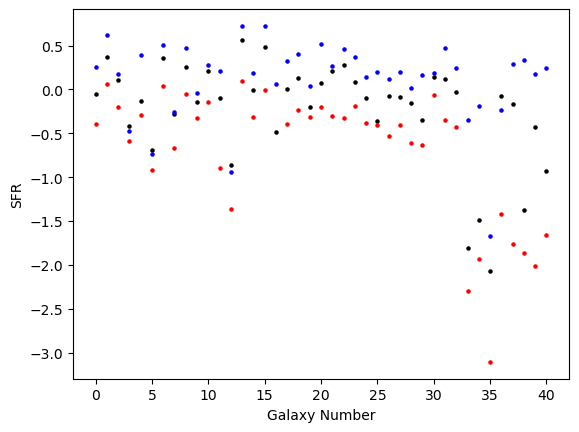

In [191]:
#comparing SFR values from different surveys and calculations
cSFR = 
for source in range(len(cSFR)):
    plt.scatter(source, cSFR[source], s=5, c='black', label = 'Coronal SFR')
    plt.scatter(source, HECATEsfr[source], s=5, c='blue', label = 'HECATE SFR')
    plt.scatter(source, s[source], s=5, c='red', label = 'Halpha SFR')

plt.xlabel('Galaxy Number')
plt.ylabel('SFR')

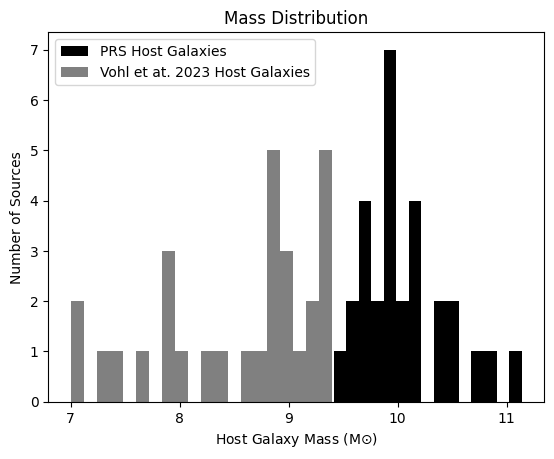

In [23]:
#plotting mass distribution of Vohl sources and final sources
plt.hist(mass[:37], bins=20, color='black',label='PRS Host Galaxies')
plt.hist(Vmass, bins=20, color='grey',label='Vohl et at. 2023 Host Galaxies')
plt.xlabel('Host Galaxy Mass (M' r'$\odot$' ')')
plt.ylabel('Number of Sources')
plt.title('Mass Distribution')
plt.legend()

0.02810034548053531 Gpc3
3.6437762179950775e-13 Gpc3


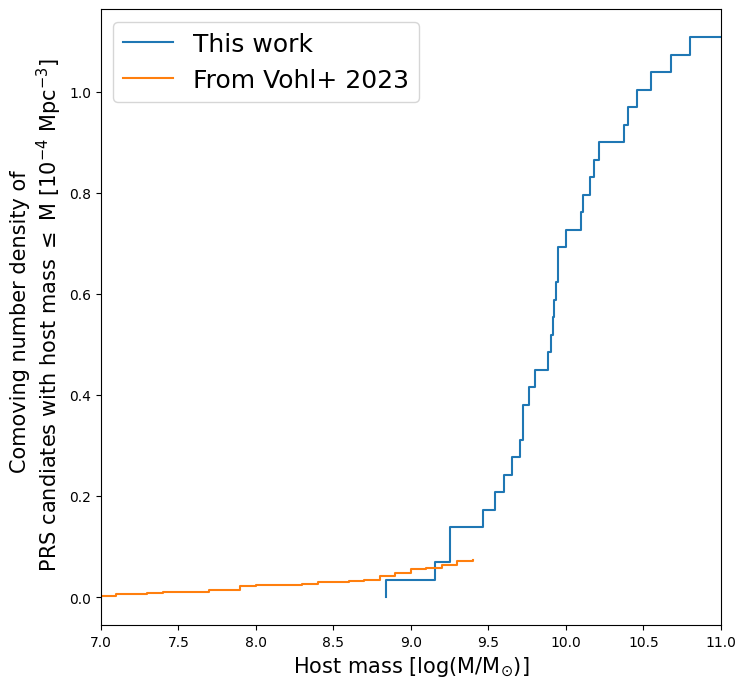

In [25]:
#cumulative mass plot to calculate volumetric number density 
#solid angle * comoving volume (z=0.043)
plt.figure(figsize=(8,8))
fraction_sky = 424/(4*np.pi*u.steradian.to(u.deg**2))
comoving_volume = cosmo.comoving_volume(z=0.043)
comoving_volume_err = cosmo.comoving_volume(z=0.00001)
print(comoving_volume.to(u.Gpc**3))
print(comoving_volume_err.to(u.Gpc**3))
plt.step(np.sort(mass[:37]), np.arange(len(mass[:37]))*1e4/fraction_sky/comoving_volume , label='This work')
fraction_sky1 = 5600/(4*np.pi*u.steradian.to(u.deg**2))
comoving_volume1 = cosmo.comoving_volume(z=0.043)
plt.step(np.sort(Vmass), np.arange(len(Vmass))*1e4/fraction_sky1/comoving_volume1 , label='From Vohl+ 2023')
plt.legend(fontsize=18)
plt.xlabel('Host mass [log(M/M$_{\odot}$)]',size=15)
plt.ylabel('Comoving number density of \n PRS candiates with host mass $\leq$ M [$10^{-4}$ Mpc$^{-3}$]',size=15)
plt.xlim(7,11)
plt.show()

In [310]:
#calculating blackhole mass plane using x-ray data
x = []
fl = []
bh = []
for source in range(len(xray)):
    if xray[source] != 0:
        d = cosmo.luminosity_distance(z = redshift[source])
        dis = d.to(u.cm).value
        x.append(xray[source] * 4 * np.pi * dis**2)
        f = LOTSSFlux[source] * 10**(-26)
        fl.append(f * 4 * np.pi * dis**2 * 1.44*10**8)
for source in range(len(x)):
    bh.append(1.09*np.log10(fl[source]/10**(38))-0.59*np.log10(x[source]/10**(40)))
print(bh)

[-3.1783673450698835, -2.2828738763858185, -2.8335916563632564, -2.810443307215744, -3.0855816497623545, -2.8573465648805048, -2.72442201639696, -3.0098734295464205, -3.0398469209374994, -2.5325307513631534, -2.966381389726959, -2.630500355563239, -2.595863349114465, -2.9475543383049025, -2.4663134481576057, -2.860312205308472, -2.887487805565094, -2.697598590479839, -3.166115117922814, -2.5941009229203535, -2.9646193771459313, -3.029226212021012, -3.1772006539166644, -2.9501406946796886, -3.0665380384420358, -2.7270332745655015, -2.8785080319436296, -2.9751341892579064, -2.9694197795618784, -3.07396746841337, -3.4990689148355236, -3.155924290612881, -2.9849550276770236]


Text(0, 0.5, 'log(M/$M_{\\odot}$)')

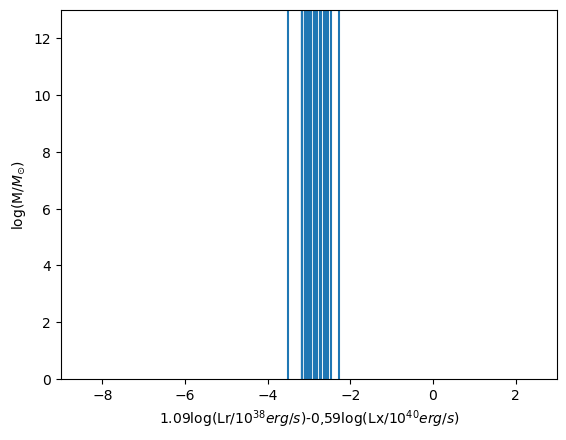

In [311]:
m = np.linspace(0,12)
for source in range(len(bh)):
    plt.axvline(bh[source])
    plt.xlim(-9,3)
    plt.ylim(0,13)
plt.xlabel('1.09log(Lr/$10^{38}erg/s$)-0,59log(Lx/$10^{40}erg/s$)')
plt.ylabel('log(M/$M_{\odot}$)')

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/3258919938.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,max(x)+10**43)


Text(0.5, 1.0, 'Radio vs X-Ray Luminosity')

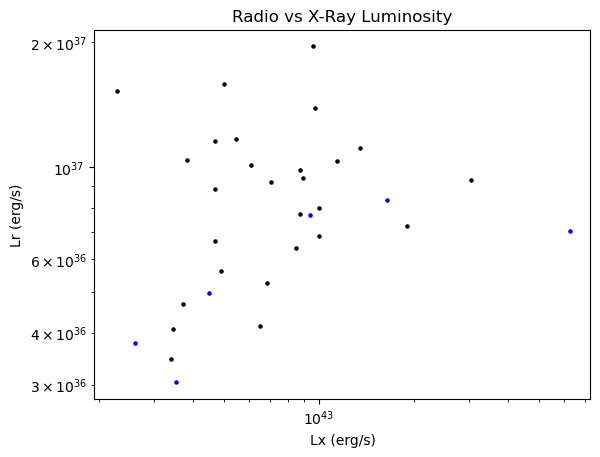

In [314]:
#plotting radio vs. x-ray luminosities
for source in range(len(x)):
    if source < 27:
        plt.scatter(x[source], fl[source], s=5, c='black')
    else:
        plt.scatter(x[source], fl[source], s=5, c='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lx (erg/s)')
plt.ylabel('Lr (erg/s)')
plt.xlim(0,max(x)+10**43)
plt.title('Radio vs X-Ray Luminosity')

Text(0.5, 0, 'Ks Absolute Magnitude')

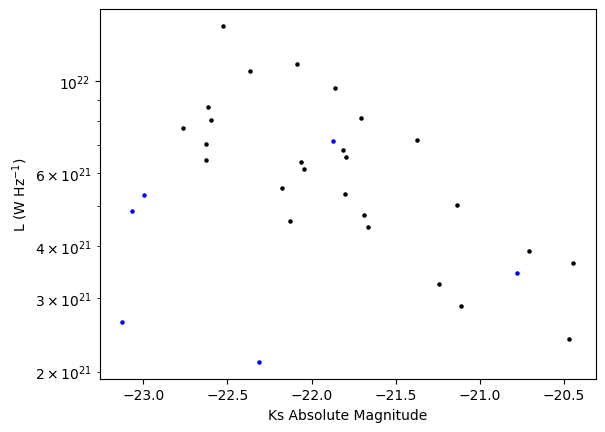

In [26]:
#plotting ks magnitude vs. radio luminosity 
for source in range(len(ks)):
    if ks[source] != 0:
        D = cosmo.luminosity_distance(z = redshift[source])
        Dis = D.to(u.parsec).value
        M = ks[source] - 2.5*np.log10((Dis/10)**2)
        if source < 27:
            plt.scatter(M, Flux[source], s=5, c='black')
        else:
            plt.scatter(M, Flux[source], s=5, c='blue')
plt.yscale('log')
plt.ylabel('L (W Hz$^{-1}$)')
plt.xlabel('Ks Absolute Magnitude')

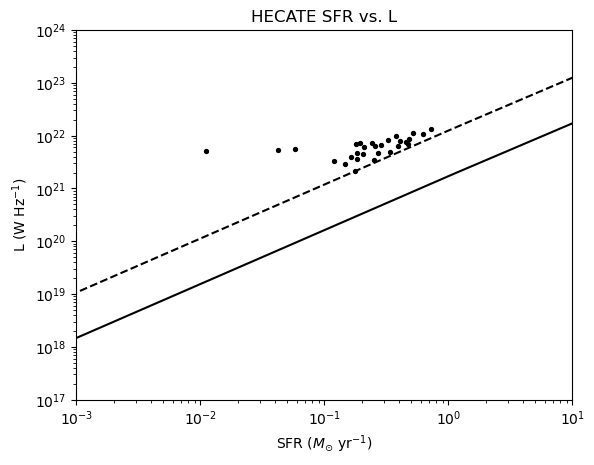

In [320]:
#don't change
def f(x):
    return (1.25*10**22)*x
x = np.linspace(-10, 100, 100)
def g(x):
    return (1.71*10**21)*x
for source in range(len(HECATEsfr)):
    plt.scatter(HECATEsfr[source], Flux[source], s = 8, color = 'black')
    #plt.text(HECATEsfr[source], Flux[source], str(source), fontsize=8)
        
plt.plot(x, f(x), linestyle='dashed',color='black')
plt.plot(x, g(x), color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('SFR ($M_{\odot}$ yr$^{-1}$)')
plt.ylim(10e16,10e23)
plt.xlim(10e-4, 10)
plt.ylabel('L (W Hz$^{-1}$)')
plt.title('HECATE SFR vs. L')
plt.show()

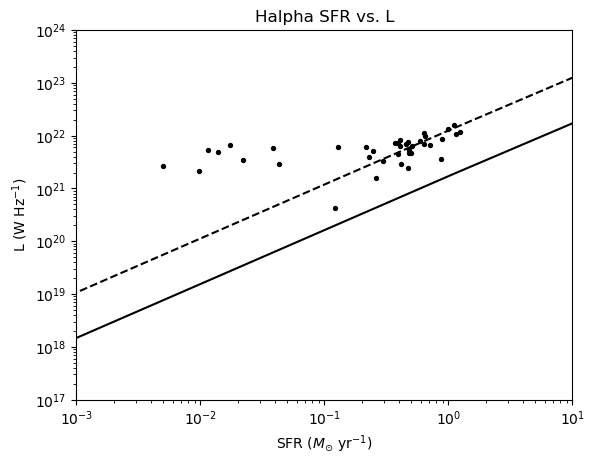

In [163]:
#don't change
def f(x):
    return (1.25*10**22)*x
x = np.linspace(-10, 100, 100)
def g(x):
    return (1.71*10**21)*x
for source in range(len(SFRcorr)):
    plt.scatter(SFRcorr[source], Flux[source], s = 8, color = 'black')
    #plt.text(HECATEsfr[source], Flux[source], str(source), fontsize=8)
        
plt.plot(x, f(x), linestyle='dashed',color='black')
plt.plot(x, g(x), color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('SFR ($M_{\odot}$ yr$^{-1}$)')
plt.ylim(10e16,10e23)
plt.xlim(10e-4, 10)
plt.ylabel('L (W Hz$^{-1}$)')
plt.title('Halpha SFR vs. L')
plt.show()

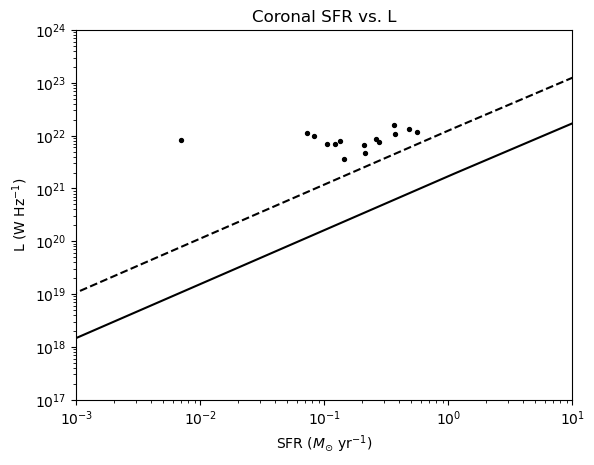

In [177]:
#don't change
cSFR = np.array(finalList['C Log(SFR)'][:41]).astype(np.float64)
def f(x):
    return (1.25*10**22)*x
x = np.linspace(-10, 100, 100)
def g(x):
    return (1.71*10**21)*x
for source in range(len(cSFR)):
    plt.scatter(cSFR[source], Flux[source], s = 8, color = 'black')
        
plt.plot(x, f(x), linestyle='dashed',color='black')
plt.plot(x, g(x), color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('SFR ($M_{\odot}$ yr$^{-1}$)')
plt.ylim(10e16,10e23)
plt.xlim(10e-4, 10)
plt.ylabel('L (W Hz$^{-1}$)')
plt.title('Coronal SFR vs. L')
plt.show()

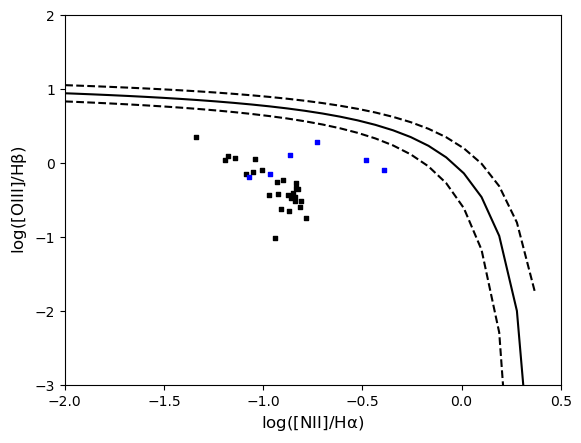

In [378]:
#BPT plot 1
NxPRS = []
NxPRS_err = []
yPRS = []
yPRS_err = []
for source in range(len(HBeta)):
    if HAlpha[source] != 0:
        NxPRS.append(NII6549[source]-HAlpha[source])
        NxPRS_err.append((NII6549[source]/HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2))
        yPRS.append(OIII5008[source]-HBeta[source])
        yPRS_err.append((OIII5008[source]/HBeta[source])*np.sqrt((OIII5008_err[source]/OIII5008[source])**2+(HBeta_err[source]/HBeta[source])**2))
        

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII
for source in range(len(NxPRS)):
    if source < 26:
        plt.scatter(NxPRS[source],yPRS[source],c='black',s=5,marker='s')
        plt.errorbar(NxPRS[source], yPRS[source],
            xerr=NxPRS_err[source],
            yerr=yPRS_err[source],
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1)
    if 26 <= source:
        plt.scatter(NxPRS[source],yPRS[source],c='blue',s=5,marker='s')
        plt.errorbar(NxPRS[source], yPRS[source],
            xerr=NxPRS_err[source],
            yerr=yPRS_err[source],
            capsize=0,
            ls="none",
            color="blue",
            elinewidth=1)
NII = np.linspace(-4.0, 0.368)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k')
plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')
plt.xlim(-2, 0.5)
plt.ylim(-3, 2)

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/2650803498.py:6: RuntimeWarning: invalid value encountered in double_scalars
  SxPRS_err.append((SIIsummed[source]-HAlpha[source])*np.sqrt((SIIsummed_err[source]/SIIsummed[source])**2+(HAlpha_err[source]/HAlpha[source])**2))


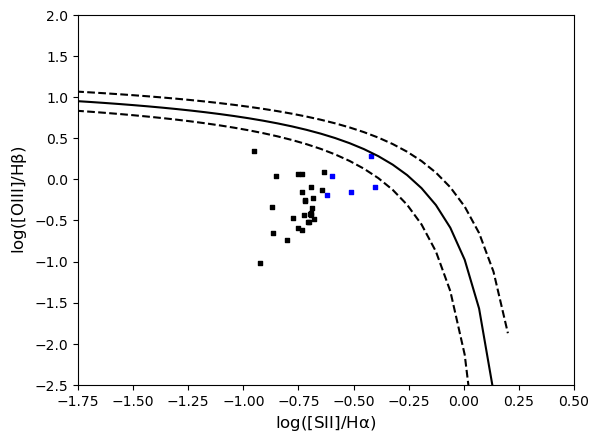

In [380]:
#BPT plot 2
SxPRS = []
SxPRS_err = []
for source in range(len(HBeta)):
    if HAlpha[source] != 0:
        SxPRS.append(SIIsummed[source]-HAlpha[source])
        SxPRS_err.append((SIIsummed[source]-HAlpha[source])*np.sqrt((SIIsummed_err[source]/SIIsummed[source])**2+(HAlpha_err[source]/HAlpha[source])**2))

from astroML.datasets.tools.sdss_fits import log_OIII_Hb_SII
for source in range(len(SxPRS)):
    if SxPRS[source] > -10:
        if source < 26:
            plt.scatter(SxPRS[source],yPRS[source],c='black',s=5,marker='s')
            plt.errorbar(SxPRS[source], yPRS[source],
                xerr=SxPRS_err[source],
                yerr=yPRS_err[source],
                capsize=0,
                ls="none",
                color="black",
                elinewidth=1)
        if 26 <= source:
            plt.scatter(SxPRS[source],yPRS[source],c='blue',s=5,marker='s')
            plt.errorbar(SxPRS[source], yPRS[source],
                xerr=SxPRS_err[source],
                yerr=yPRS_err[source],
                capsize=0,
                ls="none",
                color="blue",
                elinewidth=1)    
SII = np.linspace(-3.0, 0.2)
plt.plot(SII, log_OIII_Hb_SII(SII), '-k')
plt.plot(SII, log_OIII_Hb_SII(SII, 0.1), '--k')
plt.plot(SII, log_OIII_Hb_SII(SII, -0.1), '--k')
plt.xlim(-1.75, 0.5)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathrm{log([SII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/2517280628.py:6: RuntimeWarning: invalid value encountered in double_scalars
  OxPRS_err.append((OI6302[source]-HAlpha[source])*np.sqrt((OI6302_err[source]/OI6302[source])**2+(HAlpha_err[source]/HAlpha[source])**2))


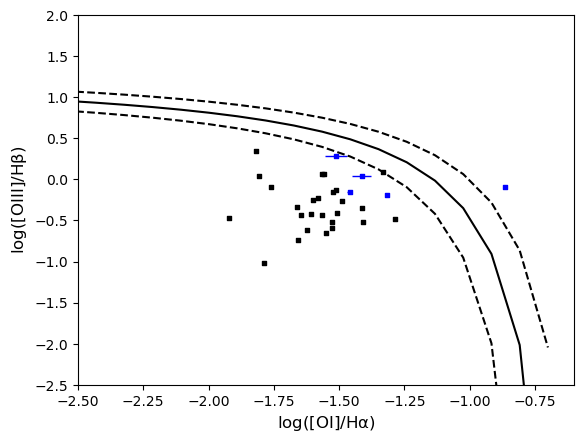

In [382]:
#BPT plot 3
OxPRS = []
OxPRS_err = []
for source in range(len(HBeta)):
    if HAlpha[source] != 0:
        OxPRS.append(OI6302[source]-HAlpha[source])
        OxPRS_err.append((OI6302[source]-HAlpha[source])*np.sqrt((OI6302_err[source]/OI6302[source])**2+(HAlpha_err[source]/HAlpha[source])**2))

from astroML.datasets.tools.sdss_fits import log_OIII_Hb_OI
for source in range(len(OxPRS)):
    if OxPRS[source] > -10:
        if source < 26:
            plt.scatter(OxPRS[source],yPRS[source],c='black',s=5,marker='s')
            plt.errorbar(OxPRS[source], yPRS[source],
                xerr=OxPRS_err[source],
                yerr=yPRS_err[source],
                capsize=0,
                ls="none",
                color="black",
                elinewidth=1)
        if 26 <= source:
            plt.scatter(OxPRS[source],yPRS[source],c='blue',s=5,marker='s')
            plt.errorbar(OxPRS[source], yPRS[source],
                xerr=OxPRS_err[source],
                yerr=yPRS_err[source],
                capsize=0,
                ls="none",
                color="blue",
                elinewidth=1)
    
OI = np.linspace(-6, -0.7)
plt.plot(OI, log_OIII_Hb_OI(OI), '-k')
plt.plot(OI, log_OIII_Hb_OI(OI, 0.1), '--k')
plt.plot(OI, log_OIII_Hb_OI(OI, -0.1), '--k')
plt.xlim(-2.5, -0.6)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathrm{log([OI]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/180226770.py:10: RuntimeWarning: invalid value encountered in log
  Nx_err.append(np.log((NII6549[source]-HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2)))


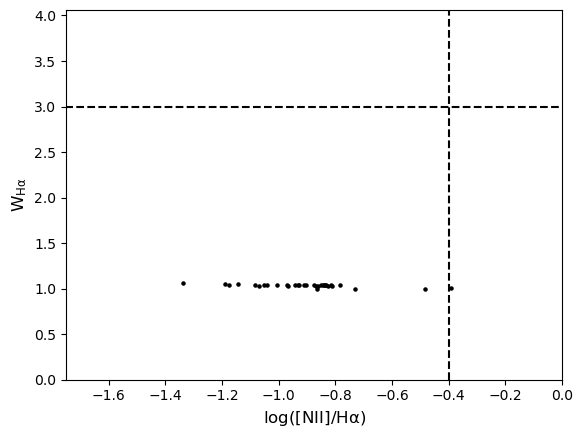

In [325]:
#WHAN plot
Walpha_err = []
Walpha = []
Nx = []
Nx_err = []
for source in range(len(Wa)):
    if HAlpha[source] != 0 and Wa[source] != 0:
        Walpha.append(Wa[source])
        Walpha_err.append(Wa[source] * np.sqrt((HAlpha_err[source]/HAlpha[source])**2+(cont_err[source]/(HAlpha[source]*Wa[source])**2)))
        Nx.append(NII6549[source]-HAlpha[source])
        Nx_err.append(np.log((NII6549[source]-HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2)))
    elif HAlpha[source] != 0:
        Walpha.append(Wa[source])
        Walpha_err.append(0)
        Nx.append(NII6549[source]-HAlpha[source])
        Nx_err.append(np.log((NII6549[source]-HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2)))

plt.scatter(Nx,Walpha,c='black',s=5)
plt.errorbar(Nx_err, Walpha,
            xerr=Nx_err,
            yerr=Walpha_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1)
plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{W_{H\alpha}}$', fontsize='large')
plt.xlim(-1.75, 0)
plt.ylim(0,max(Walpha)+3)
plt.plot((-0.4,-0.4),(0,max(Walpha)+15), 'k--', scaley = True, scalex= True)
plt.plot((-3,0),(3,3), 'k--', scaley = True, scalex= True)


In [389]:
#specific SFR vs. mass plot
def sSFR_plot():
        fig, ax = plt.subplots(figsize=(8, 10))
        img = plt.imread("SSFR.png")
        #ax.imshow(img, aspect="auto", extent=[8,12.5,-15,-8])
        for source in range(len(sSFR)):
                if sSFR[source] < -1:
                        if source < 27:
                                ax.scatter(mass[source], sSFR[source], color="magenta",s=15,marker='D')
                        if 27 <= source:
                                ax.scatter(mass[source], sSFR[source], color="blue",s=15,marker='D')
        ylabel = "log(sSFR)"
        xlabel = "log(Mass)"
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=18)
        ax.tick_params(axis="both", which="both", labelsize=16, length=0)
        ax.set_title('Specific SFR vs. Mass')
        plt.xlim(8,12.5)
        plt.show()
        #plt.close()

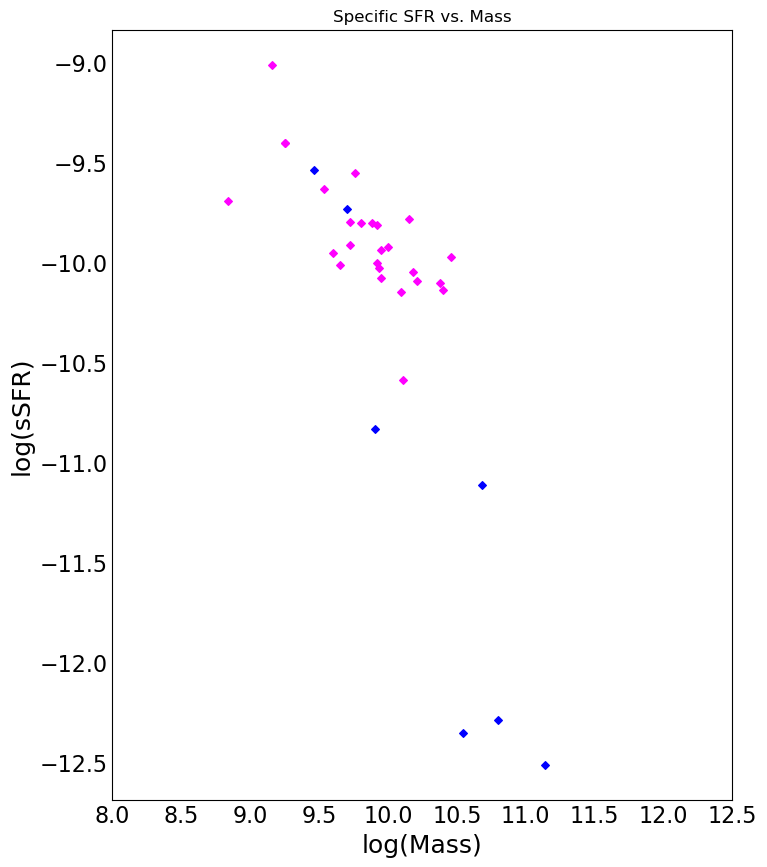

In [390]:
sSFR = np.array(finalList['Log(sSFR)'][:41]).astype(np.float64)
sSFR_plot()

Text(0.5, 1.0, 'Redshift Distribution')

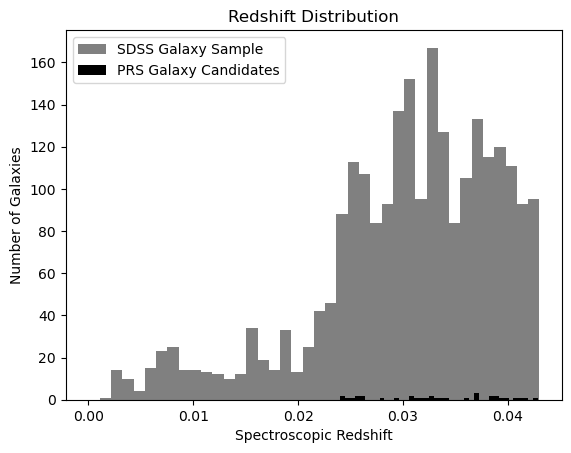

In [329]:
#spectroscopic redshfit distribution plot
SDSSz = []
for source in range(len(SDSS)):
    if SDSS[source]['zsp'] != 0:
        SDSSz.append(SDSS[source]['zsp'])
plt.hist(SDSSz, range=(0,0.043), bins = 40, color='grey',label='SDSS Galaxy Sample')
plt.hist(redshift, bins = 40,color='black',label='PRS Galaxy Candidates')
plt.legend()
plt.ylabel('Number of Galaxies')
plt.xlabel('Spectroscopic Redshift')
plt.title('Redshift Distribution')


In [ ]:
#Chance Assocaition Probability

In [330]:
v = Vizier(columns=["*", "+_r"])
DR1cap = []
for source in range(len(SDSS)):
    dr1 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = 40 * u.arcsec, catalog = 'J/A+A/622/A1/lotssdr1')
    if len(dr1) > 0:
        DR1cap.append(dr1[0][0])
print(len(DR1cap))

3986


In [331]:
ratio = []
calculated = []
inEnvelope = []
for source in range(len(DR1cap)):
    ratio.append(DR1cap[source]['Sint']/DR1cap[source]['Speak'])
    calculated.append(offset1 + A1 * (DR1cap[source]['Speak']/DR1cap[source]['rms']) ** B1)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        inEnvelope.append(True)
    else:
        inEnvelope.append(False)
        
compact1cap = []
for source in range(len(inEnvelope)):
    if inEnvelope[source] == True:
        compact1cap.append(DR1cap[source])
print(len(compact1cap))

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/4042130290.py:5: RuntimeWarning: divide by zero encountered in float_scalars
  ratio.append(DR1cap[source]['Sint']/DR1cap[source]['Speak'])
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_3257/4042130290.py:6: RuntimeWarning: divide by zero encountered in power
  calculated.append(offset1 + A1 * (DR1cap[source]['Speak']/DR1cap[source]['rms']) ** B1)


2071


In [332]:
Compact1cap = []
for source in range(len(compact1cap)):
    if compact1cap[source]['Sint'] > 0.8:
        Compact1cap.append(compact1cap[source])
print(len(Compact1cap))

1166


In [333]:
c1cap = []
for source in range(len(Compact1cap)):
    if Compact1cap[source]['Type'] == 'S':
        c1cap.append(Compact1cap[source])
print(len(c1cap))

1106


In [334]:
v = Vizier(columns=["*", "+_r"])
DR2cap = []
for source in range(len(SDSS)):
    dr2 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = 40 * u.arcsec, catalog = 'J/A+A/659/A1/catalog')
    if len(dr2) > 0:
        DR2cap.append(dr2[0][0])
print(len(DR2cap))

4863


In [335]:
ratio2 = []
calculated2 = []
inEnvelope2 = []
for source in range(len(DR2cap)):
    ratio2.append(DR2cap[source]['SpeakTot']/DR2cap[source]['Speak'])
    calculated2.append(offset2 + A2 * (DR2cap[source]['Speak']/DR2cap[source]['Islrms']) ** B2)
for source in range(len(ratio2)):
    if ratio2[source] < calculated2[source]:
        inEnvelope2.append(True)
    else:
        inEnvelope2.append(False)
        
compact2cap = []
for source in range(len(inEnvelope2)):
    if inEnvelope2[source] == True:
        compact2cap.append(DR2cap[source])
print(len(compact2cap))

2474


In [336]:
Compact2cap = []
for source in range(len(compact2cap)):
    if compact2cap[source]['SpeakTot'] > 1.23:
        Compact2cap.append(compact2cap[source])
print(len(Compact2cap))

743


In [337]:
c2cap = []
for source in range(len(Compact2cap)):
    if Compact2cap[source]['SCode'] == 'S':
        c2cap.append(Compact2cap[source])
print(len(c2cap))

692


In [338]:
off1 = []
off2 = []
for source in range(len(c1cap)):
    off1.append(c1cap[source]['_r'])
for source in range(len(c2cap)):
    off2.append(c2cap[source]['_r'])

0.22165714028534136


Text(0.5, 1.0, 'Radio source-Galaxy Offset Distribution')

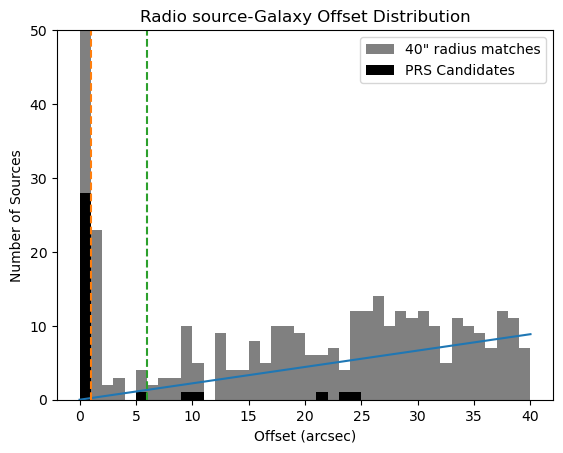

In [339]:
prsoffset = np.array(finalList['Offset'][:41]).astype(np.float64)
plt.hist(off2,bins=40,color='grey',histtype='barstacked',stacked=True,range=(0,40),label='40" radius matches')
plt.hist(prsoffset,histtype='barstacked',stacked=True,bins=40, range=(0,40),color='black',label='PRS Candidates')
y = np.array([0,   2.,   3.,   3.,  10.,   5.,
          0.,   9.,   4.,   4.,   8.,   5.,  10.,  10.,   9.,   6.,   6.,
          7.,   4.,  12.,  12.,  14.,  10.,  12.,  11.,  12.,  10.,   5.,
         11.,  10.,   9.,   7.,  12.,  11.,   7.])
x = np.array([0,   7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40.])
a,b = np.polyfit(x,y,1)
print(a) 
z = np.linspace(0,40)
plt.plot(z, a*z)
plt.plot((1,1),(0,420), '--', scaley = False)
plt.plot((6,6),(0,420), '--', scaley = False)
plt.legend()
plt.ylim(0,50)
plt.xlabel('Offset (arcsec)')
plt.ylabel('Number of Sources')
plt.title('Radio source-Galaxy Offset Distribution')

In [340]:
#calculating chance association
chance2 = a * (1)
print(chance2)
chance6 = a * (1+2+3+4+5+6)
print(chance6)

0.22165714028534136
4.654799945992169


In [109]:
V = Vizier(catalog = 'J/A+A/622/A1/lotssdr1',columns = ['**'])
V.ROW_LIMIT = 10000000000
d1 = V.query_constraints(RAJ2000 = '160.5 .. 233', DEJ2000 = '44.5 .. 57.5')

In [105]:
V = Vizier(catalog = 'J/A+A/659/A1/catalog',columns = ['**'])
V.ROW_LIMIT = 10000000000
d2 = V.query_constraints(RAJ2000 = '160.5 .. 233', DEJ2000 = '44.5 .. 57.5')

In [115]:
ratio = []
calculated = []
inEnvelope = []
ccc1 = []
ccc1RA = []
ccc1DEC = []
for source in range(len(d1[0])):
    ratio.append(d1[0][source]['Sint']/d1[0][source]['Speak'])
    calculated.append(offset1 + A1 * (d1[0][source]['Sint']/d1[0][source]['rms']) ** B1)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        if d1[0][source]['Sint'] > 0.8:
            if d1[0][source]['Type'] == 'S':
                ccc1.append(d1[0][source])
                ccc1RA.append(d1[0][source]['RAJ2000'])
                ccc1DEC.append(d1[0][source]['DEJ2000'])

ratio = []
calculated = []
inEnvelope = []
ccc2 = []
ccc2RA = []
ccc2DEC = []
for source in range(len(d2[0])):
    ratio.append(d2[0][source]['SpeakTot']/d2[0][source]['Speak'])
    calculated.append(offset2 + A2 * (d2[0][source]['SpeakTot']/d2[0][source]['Islrms']) ** B2)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        if d2[0][source]['SpeakTot'] > 1.23:
            if d2[0][source]['SCode'] == 'S':
                ccc2.append(d2[0][source])
                ccc2RA.append(d2[0][source]['RAJ2000'])
                ccc2DEC.append(d2[0][source]['DEJ2000'])

print(len(ccc1))
print(len(ccc2))

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_84118/2277556603.py:8: RuntimeWarning: divide by zero encountered in float_scalars
  ratio.append(d1[0][source]['Sint']/d1[0][source]['Speak'])
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_84118/2277556603.py:9: RuntimeWarning: divide by zero encountered in power
  calculated.append(offset1 + A1 * (d1[0][source]['Sint']/d1[0][source]['rms']) ** B1)


102652
90054


In [301]:
max_sep = 2.0 * u.arcsec
c = SkyCoord(ra=ccc1RA*u.degree, dec=ccc1DEC*u.degree)
catalog = SkyCoord(ra=ccc2RA*u.degree, dec=ccc2DEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
dr1_matches = c[sep_constraint]
dr2_matches = catalog[idx[sep_constraint]]
print(len(dr1_matches))

58352


In [302]:
#calculating chance association
pcc2 = len(dr1_matches) * np.pi * (3282/424) * len(SDSS) * (9.41 * 10 ** -11)
print(pcc2)
pcc6 = len(dr1_matches) * np.pi * (3282/424) * len(SDSS) * (8.47 * 10 ** -10)
print(pcc6)

1.0951856058137777
9.857834305252602


In [ ]:
#contour images

INFO: Auto-setting vmin to -8.937e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.481e-01 [aplpy.core]


/Users/sarahpelesky/opt/anaconda3/lib/python3.9/site-packages/aplpy/core.py:1176: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  s = self.ax.scatter(xw, yw, transform=self.ax.get_transform(coords_frame), **kwargs)
/Users/sarahpelesky/opt/anaconda3/lib/python3.9/site-packages/aplpy/core.py:1176: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  s = self.ax.scatter(xw, yw, transform=self.ax.get_transform(coords_frame), **kwargs)


INFO: Auto-setting vmin to -8.733e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.183e-01 [aplpy.core]


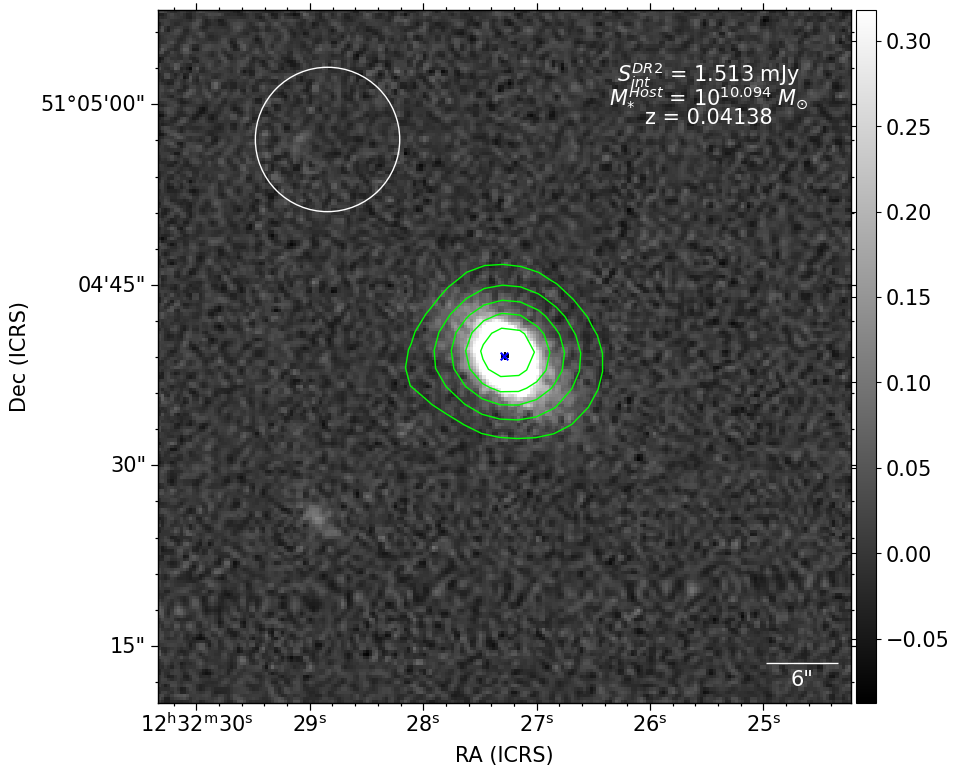

In [342]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
filename = get_pkg_data_filename('SDSS 1.fits')
hdu = fits.open(filename)[0]
hdu.header
gc = aplpy.FITSFigure('SDSS 1.fits')
gc.show_colorscale()
gc.add_colorbar()
coords = [SDSSRA[0],SDSSDEC[0]]
Lcoords = [LOTSSRA[0], LOTSSDEC[0]]
m = mass[0]
l = LOTSSFlux[0]
r = redshift[0]
gc.recenter(coords[0], coords[1], 0.008, 0.008)
gc.add_label(coords[0] - 0.0075, coords[1] + 0.0065, '$S_{int}^{DR2}$ = '+f'{l} mJy' ,color='white',size=15)
gc.add_label(coords[0] - 0.0075, coords[1] + 0.006, '$M_{*}^{Host}$ = '+f'$10^{{{m}}}$'+' $M_{\odot}$' ,color='white',size=15)
gc.add_label(coords[0] - 0.0075, coords[1] + 0.0055, f'z = {r}' ,color='white',size=15)
gc.show_circles(coords[0] + 0.0065, coords[1] + 0.005, radius = 6 /3600, coords_frame= 'world', color = 'white')
gc.show_markers(Lcoords[0], Lcoords[1], coords_frame= 'world', facecolor = 'black', edgecolor = 'black', marker = '+')
gc.show_markers(coords[0], coords[1], coords_frame= 'world', facecolor = 'blue', edgecolor = 'blue', marker = 'x')
gc.add_scalebar(6*u.arcsec)
gc.scalebar.set_color('white')
gc.scalebar.set_label('6"')
gc.scalebar.set_font(size=15, weight=1, \
                      stretch='normal', family='sans-serif', \
                      style='normal', variant='normal')
gc.show_regions('DR2 1.reg')
gc.show_grayscale()
gc.colorbar.set_font(size=15, weight=1, \
                      stretch='normal', family='sans-serif', \
                      style='normal', variant='normal')
gc.axis_labels.set_font(size=15, weight=1, \
                         stretch='normal', family='sans-serif', \
                         style='normal', variant='normal')
gc.tick_labels.set_font(size=15, weight=1, \
                         stretch='normal', family='sans-serif', \
                         style='normal', variant='normal')
gc.ticks.set_length(5)
gc.save('cont 1.png')